In [449]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py


py.init_notebook_mode(connected=True)
#py.renderers.default = "notebook"


from collections import Counter

import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import csv

import math

# ignore category data less than this threshold
THRESHOLD = 4 


def double_bar_chart(qnum, qtext, ds1_name, data_series_1, ds2_name, data_series_2):

    
    ct = f"{qnum} : {qtext} (n={data_series_1.sum()+data_series_2.sum()})"
    
    # Create the figure with stacked bars
    fig = go.Figure(data=[
        go.Bar(name=ds1_name, x=data_series_1.index, y=data_series_1.values),
        go.Bar(name=ds2_name, x=data_series_2.index, y=data_series_2.values)
    ])

    # Update the layout to stack the bars
    fig.update_layout(
        barmode='stack',
        title=ct,
        plot_bgcolor="#FFFFFF",
        showlegend=True,
        xaxis={'categoryorder':'total descending'})

    fig.update_layout(width=900, height=500, bargap=0.05)
    
    # Show the plot
    fig.show()

    #Anything interesting in Other ?

    qother=qnum+"Other"

    others=[]
    if qother in raw_df.columns:
        print ("Found - " + qother)
        for v in raw_df[qother]:
           others.append (v)

    # Create a Counter object to count the frequency of each string
    frequency_counts = Counter(others)

    # Convert the Counter to a list of tuples (unique string, count)
    unique_entries_with_counts = list(frequency_counts.items())

    # Sort by frequency (descending)
    sorted_by_frequency = sorted(unique_entries_with_counts, key=lambda x: x[1], reverse=True)

    listofothers=[]
    
    for x in sorted_by_frequency:
        if (not (str(x[0]) == "0"))   & (x[1] > THRESHOLD):
            listofothers.append( (f"{x[0]}({x[1]})"))
  

    print(f"Other answers with frequency greater than {THRESHOLD} : {" ".join(listofothers)}")
  


In [450]:
FILENAME = "raw-data-102624.xlsx"

#read questions from separate file
questions = { }
with open('questions.csv') as f:
    reader = csv.reader(f, skipinitialspace=True)
    questions = dict(reader)


raw_df = pd.read_excel(FILENAME, engine="openpyxl")

# replace Excel null columns
raw_df.fillna (value=0, inplace=True)

#drop columns we don't care about
raw_df.drop (columns=['#', "Response Type", "Start Date (UTC)", "Stage Date (UTC)", "Submit Date (UTC)", "Network ID", "Tags"], inplace=True)

#rename columns

raw_df.rename( columns=
              {
                questions['Q1'] : 'Q1',
                questions['Q2'] : 'Q2',
                'Other' : 'Q2Other',
                'How many staff does your organization employ?': 'Q3', 
                'What is your organization’s annual revenue?' : 'Q4',
                'How many years has your organization been using container technology?' : 'Q5',
                'How many years has your organization been using CI/CD ?' : 'Q6',
                'How many years has your organization been using GitOps?' : 'Q7',
                'What is your current role?' : 'Q8',
                'Other.1' : 'Q8Other',
                questions['Q9'] : 'Q9',
                questions['Q10'] : 'Q10',
                questions['Q11'] : 'Q11',
                questions['Q12.A1'] : 'Q12.A1',
                questions['Q12.A2'] : 'Q12.A2',
                questions['Q12.A3'] : 'Q12.A3',
                questions['Q12.A4'] : 'Q12.A4',
                questions['Q12.A5'] : 'Q12.A5',
                questions['Q12.A6'] : 'Q12.A6',
                questions['Q12.A7'] : 'Q12.A7',
                questions['Q12.A8'] : 'Q12.A8',
                questions['Q16'] : 'Q16',
                questions['Q17'] : 'Q17'
              },
              inplace=True)


/opt/anaconda3/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



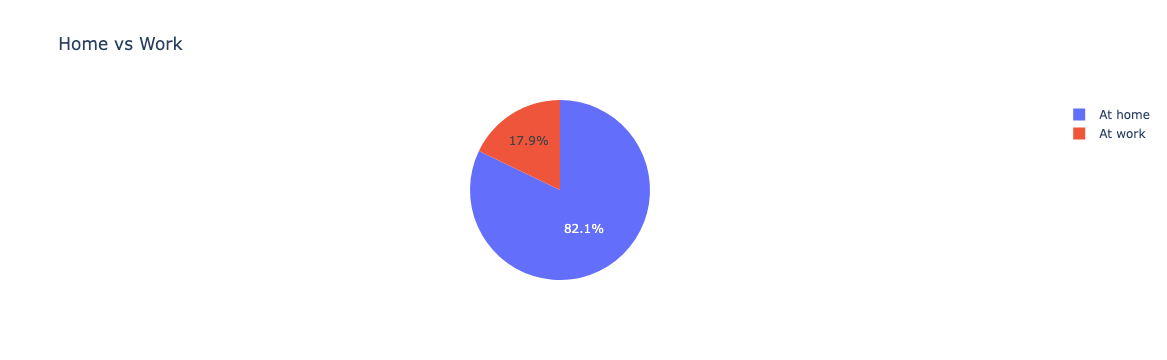

In [451]:
# Q1 - home or work ?
#

temp_series = raw_df['Q1'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series)))


trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Home vs Work'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="home-work")



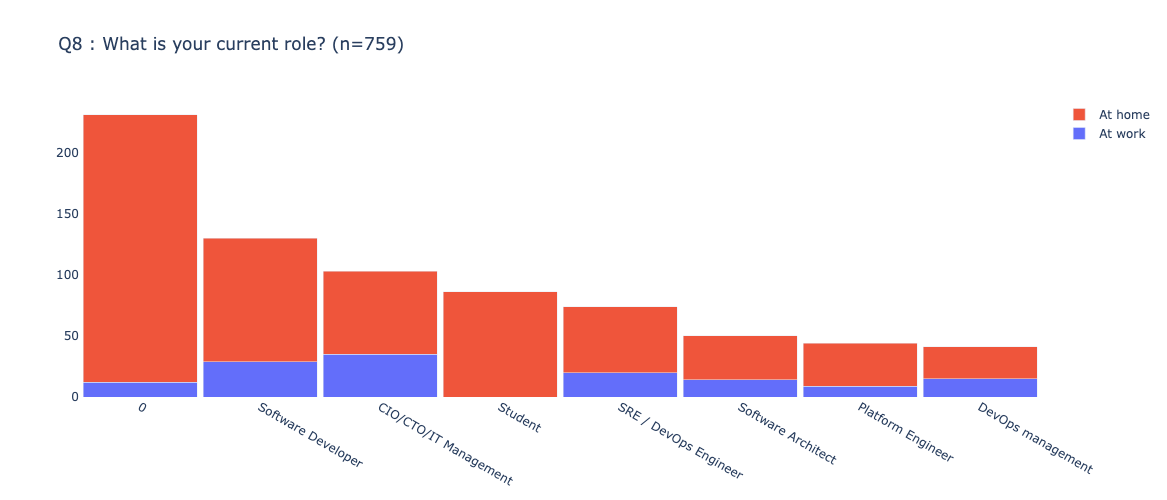

Found - Q8Other
Other answers with frequency greater than 4 : ['Hobbyist(9)', 'Home user(7)', 'Hobby(5)', 'Retired(5)']


In [452]:
# split into two data sets depending on Home or Work usage

CHOME = "At home"
CWORK = "At work"

home_df = raw_df.query("`Q1` == @CHOME").copy()
work_df = raw_df.query("`Q1` == @CWORK").copy()




#
# Questions Q3 to Q11 are the same data format
#

#selected_qs = ['Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']
selected_qs = ['Q8']
for key in selected_qs:
    if key in questions:
        value = questions[key]
        double_bar_chart(
                 key,
                 questions[key], 
                 CWORK, work_df[key].value_counts()[lambda x: x > THRESHOLD], 
                 CHOME, home_df[key].value_counts()[lambda x: x > THRESHOLD])

